In [ ]:
from google.colab import files
from google.colab import drive  
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9a3bcad7-585c-cbc6-bd01-b2ae5557190c)


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  2 12:31:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Unzipping train-valid-zip from GDrive to the colab's local storage.

In [ ]:
!unzip "/content/gdrive/MyDrive/dl_reddit/train_set.zip" -d "/content"
!unzip "/content/gdrive/MyDrive/dl_reddit/valid_set.zip" -d "/content"
!unzip "/content/gdrive/MyDrive/dl_reddit/test_set.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/test_set/0/2021.10.16_90.png  
  inflating: /content/test_set/0/2021.10.14_85.png  
  inflating: /content/test_set/0/2021.09.22_93.png  
  inflating: /content/test_set/0/2021.09.13_66.png  
  inflating: /content/test_set/0/2021.09.11_41.png  
  inflating: /content/test_set/0/2021.08.29_124.png  
  inflating: /content/test_set/0/2021.09.14_103.png  
  inflating: /content/test_set/0/2021.10.03_135.png  
  inflating: /content/test_set/0/2021.10.01_118.png  
  inflating: /content/test_set/0/2021.09.22_134.png  
  inflating: /content/test_set/0/2021.09.24_64.png  
  inflating: /content/test_set/0/2021.08.26_117.png  
  inflating: /content/test_set/0/2021.09.05_90.png  
  inflating: /content/test_set/0/2021.09.03_126.png  
  inflating: /content/test_set/0/2021.08.27_40.png  
  inflating: /content/test_set/0/2021.09.29_157.png  
  inflating: /content/test_set/0/2021.09.22_47.png  
  inflating: /content/test_set/0/2021.09

Calculating weigths used for our imbalanced image classification task. There are other methods for dealing with the imbalance such as 
- Undersampling the dominating class => too much information loss 
- Oversampling or any variants of SMOTE => dataset would be even bigger and with the constraints we have with time and gpu resources, it's not possible 

That's why we stick with class weighting. 

Formula for calculating weights for 'balanced' class weights. 
w_j = n_samples / (n_classes * n_samples_j)

In [1]:
train0_lst_num = !ls "/content/train_set/0" | wc -l
train1_lst_num = !ls "/content/train_set/1" | wc -l

num_train0 = float(train0_lst_num[0])
num_train1 = float(train1_lst_num[0])
num_train = num_train0 + num_train1
n_classes = 2

w0 = num_train/(n_classes * num_train0)  #weight for class 0
w1 = num_train/(n_classes * num_train1)  #weight for class 1 

print('Weight for Class0:', w0)
print('Weight for Class1:', w1)


Weight for Class0: 0.5268318160201101
Weight for Class1: 9.817297040670992


Copying the corresponding csv-s to the local storage


In [2]:
!cp "/content/gdrive/MyDrive/dl_reddit/train_set.csv" "./"
!cp "/content/gdrive/MyDrive/dl_reddit/valid_set.csv" "./"
!cp "/content/gdrive/MyDrive/dl_reddit/test_set.csv" "./"

# **New format still in Tensorflow**

In [3]:
!pip install tensorflow-addons
!pip install vit-keras

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve, average_precision_score, roc_auc_score, roc_curve
from vit_keras import vit, utils, visualize

Number of instances in each set. 

In [5]:
main_dir = '/content/'
subdir_lst = ['train_set', 'valid_set/', 'test_set']

for subdir in subdir_lst:
  total = 0
  for root, dirs, files in os.walk(main_dir + subdir):
    total += len(files)

  print(subdir, '-------', total, 'instances')

train_set ------- 248142 instances
valid_set/ ------- 5000 instances
test_set ------- 5000 instances


Creating tf.data.Dataset from image files in a directory.

In [6]:
train_dir = '/content/train_set/'
validation_dir = '/content/valid_set/'
test_dir = '/content/test_set/'

BATCH_SIZE = 128
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            color_mode = 'rgb',
                                                            seed = 42,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 color_mode = 'rgb',
                                                                 seed = 42,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           color_mode = 'rgb',
                                                           shuffle=False,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)



class_names = validation_dataset.class_names
print('Class names:', class_names)


Found 248142 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Class names: ['0', '1']


Some pics sample with their label

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


Creating a sequence of data agumentation that will be called with the help of Functional API later on. 
Data Augumentation's elements are self-suficcient 

In [7]:
data_augmentation = tf.keras.Sequential([                              
  tf.keras.layers.RandomContrast(0.3),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
  tf.keras.layers.RandomZoom(height_factor=0.3, width_factor=0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2)
])


Demonstrating the result of data-auugumentation on a simple example 

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


Prefatching datasets in order for the training to parallalize the execution of step s and reading the data for step s+1. 

Using cache was also an option but the amount of RAM was not enough. 

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# ViT B32

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)

vitbase_model = vit.vit_b32(
        image_size = IMG_SIZE[0],
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

vitbase_model.trainable = False

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [21]:
vitb32_model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(scale=1./255),
        vitbase_model,
        tf.keras.layers.Flatten(),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(rate=0.5),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ],
    name = 'vision_transformer')



In [22]:
learning_rate = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

vitb32_model.compile(optimizer = optimizer, 
              loss = 'binary_crossentropy', 
              weighted_metrics=['accuracy'])

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

lr_reduc = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                            patience=3,
                            verbose=1,
                            factor=0.2,
                            min_lr=0.00001)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='vitb32.hdf5', save_best_only=True, verbose=1)

callbacks = [checkpointer, early_stopping, lr_reduc]

In [24]:
cw={0: w0, 1: w1}
initial_epochs = 15

history_vitb32 = vitb32_model.fit(train_dataset,
                    epochs = initial_epochs,
                    validation_data = validation_dataset,
                    class_weight = cw,
                    workers = 8,
                    use_multiprocessing = True,
                    callbacks = callbacks)


Epoch 1/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.5918
Epoch 00001: val_loss improved from inf to 0.64827, saving model to vitb32.hdf5
1939/1939 [==============================] - 1567s 797ms/step - loss: 0.6709 - accuracy: 0.5918 - val_loss: 0.6483 - val_accuracy: 0.6224 - lr: 0.0010
Epoch 2/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6105
Epoch 00002: val_loss improved from 0.64827 to 0.64671, saving model to vitb32.hdf5
1939/1939 [==============================] - 1551s 797ms/step - loss: 0.6519 - accuracy: 0.6105 - val_loss: 0.6467 - val_accuracy: 0.5840 - lr: 0.0010
Epoch 3/15
1939/1939 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.6159
Epoch 00003: val_loss did not improve from 0.64671
1939/1939 [==============================] - 1570s 806ms/step - loss: 0.6470 - accuracy: 0.6159 - val_loss: 0.6581 - val_accuracy: 0.5628 - lr: 0.0010
Epoch 4/15
1939/1939 [================

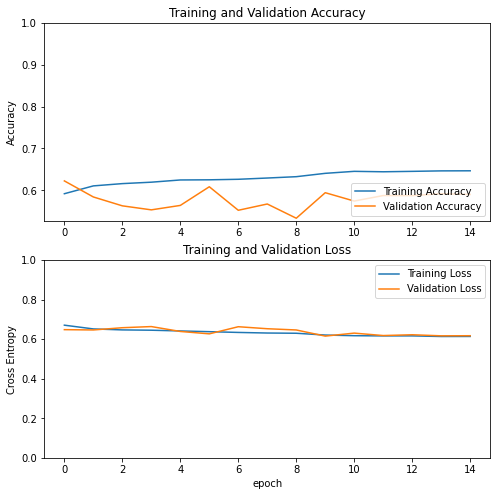

In [25]:
acc = history_vitb32.history['accuracy']
val_acc = history_vitb32.history['val_accuracy']

loss = history_vitb32.history['loss']
val_loss = history_vitb32.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
loss, accuracy = vitb32_model.evaluate(test_dataset)
print("loss: {:.4f}".format(loss))
print("accuracy: {:.4f}".format(accuracy))

40/40 [==============================] - 32s 787ms/step - loss: 0.6091 - accuracy: 0.6064
loss: 0.6091
accuracy: 0.6064


In [27]:
y_true = np.concatenate([label for _, label in test_dataset], axis=0)
Y_prob = vitb32_model.predict(test_dataset)
y_pred = np.where(Y_prob < 0.5, 0, 1)  #if the probability for an image to be dank (aka to be classfied as 1) is less than 0.5 it will be labelled as 0.

### Reshaping for sklearn classification_report and for AUC plots
Y_prob = Y_prob.reshape(y_true.shape)
y_pred = y_pred.reshape(y_true.shape)


In [28]:
target_names = ['0', '1']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           0     0.9697    0.6055    0.7455      4760
           1     0.0740    0.6250    0.1323       240

    accuracy                         0.6064      5000
   macro avg     0.5218    0.6152    0.4389      5000
weighted avg     0.9267    0.6064    0.7160      5000



PR AUC: 0.09289250596229823


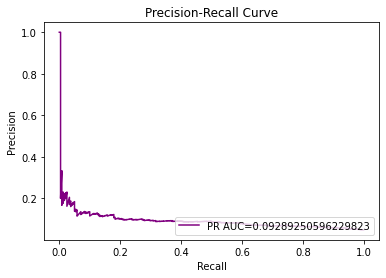

In [29]:
precision, recall, thresholds = precision_recall_curve(y_true, Y_prob)
auc_precision_recall = auc(recall, precision)
print('PR AUC:', auc_precision_recall)

plt.plot(recall, precision, label="PR AUC="+str(auc_precision_recall), color = 'purple')
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc=4)
plt.show()


ROC AUC: 0.6655335259103641


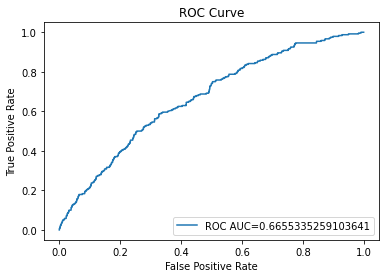

In [30]:
fpr, tpr, _ = roc_curve(y_true,  Y_prob)
rocAUC_score = roc_auc_score(y_true, Y_prob)

print('ROC AUC:', rocAUC_score)

#create ROC curve
plt.plot(fpr,tpr,label="ROC AUC="+str(rocAUC_score))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()